In [1]:
import signaltools
from appgeopy import *
from my_packages import *

In [2]:
# _______________________________________________________________________
# Load HDF5 File and Extract Dataset Information
hdf5_fpath = r"20240903_GWL_CRFP.h5"

with h5py.File(hdf5_fpath, "r") as hdf5_file:
    # Extract existing data and available datasets
    existing_data_dict = h5pytools.hdf5_to_data_dict(hdf5_file)
    available_datasets = h5pytools.list_datasets(hdf5_file)

    # Extract the 'date' array and convert to a datetime index
    datetime_array = pd.to_datetime(existing_data_dict["date"], format="%Y%m%d")

# _______________________________________________________________________
# Get list of stations
stations = sorted(set([elem.split("/")[0] for elem in available_datasets if "date" not in elem]))

In [3]:
# _______________________________________________________________________
# Default parameters (can be modified)
detrend_degree = 3
smoothing_window = 31  # Will be dynamically calculated
polyorder = 5
min_distance = None  # Will be dynamically calculated
output_folder = "temp4_v2"

In [4]:
# station = stations[0]

for station in stations[:5]:
    # Extract the station's data from the dictionary
    station_data = existing_data_dict[station]
    
    # Filter wellcodes that contain exactly 3 items (indicating wellcode structure)
    wellcodes = [elem for elem, val in station_data.items() if isinstance(val, dict) and len(val) == 3]
    
    # wellcode = wellcodes[0]
    for wellcode in wellcodes:
        print(f"  Processing wellcode: {wellcode}")
        output_savename = f"{station}_{wellcode}"
        
        # Extract and process time series data
        model_gwl_arr = station_data[wellcode]["measure"]["model"]
        model_gwl_series = pd.Series(data=model_gwl_arr, index=datetime_array)
        
        # Extract valid series data (removing NaNs)
        valid_idx_start = model_gwl_series.first_valid_index()
        valid_idx_end = model_gwl_series.last_valid_index()
        valid_gwl_series = model_gwl_series[valid_idx_start:valid_idx_end]
        # ______________________________________________________________
        
        original_data = valid_gwl_series.values
        dates = valid_gwl_series.index
        
        # ______________________________________________________________
        # Step 1: Detrend and smooth the series
        # Detrend the series using the predefined degree
        trend, detrended_series = signaltools.get_seasonal_and_trend_data(series=valid_gwl_series, detrend_degree=detrend_degree)
        
        # Compute the smoothing window if not provided
        if smoothing_window is None:
            smoothing_window = signaltools.compute_smoothing_window(len(detrended_series))
        
        # Smooth the detrended series
        smoothed_series = signaltools.smooth_time_series(
            detrended_series, window_length=smoothing_window, polyorder=polyorder
        )
        
        # ______________________________________________________________
        # Step 2: Detect peaks and troughs
        # Compute minimum distance between peaks if not provided
        if min_distance is None:
            min_distance = signaltools.compute_dynamic_distance(smoothed_series)
        
        # Detect peaks and troughs
        peaks, troughs = signaltools.detect_peaks_troughs(smoothed_series, distance=min_distance)
        
        output_peak_table = pd.DataFrame(
            {"indexes": peaks, "dates": dates[peaks], "values": original_data[peaks]}
        )
        
        output_trough_table = pd.DataFrame(
            {"indexes": troughs, "dates": dates[troughs], "values": original_data[troughs]}
        )
        
        
        # ______________________________________________________________
        # Step 3: Save the results to Excel file
        # Define the save path for the Excel file
        excel_savepath = os.path.join(output_folder, f"{output_savename}.xlsx")
        
        # Save peaks and troughs to Excel
        output_peak_table.to_excel(excel_savepath, sheet_name="peaks", index=False)
        data_io.save_df_to_excel(
            df_to_save=output_trough_table, filepath=excel_savepath, sheet_name="troughs", verbose=False, index=False
        )
        
        print(f"  Saved results for {wellcode} to {excel_savepath}")
        
        print("Processing complete.")

  Processing wellcode: 10070111
  Saved results for 10070111 to temp4_v2\ANHE_10070111.xlsx
Processing complete.
  Processing wellcode: 10070121
  Saved results for 10070121 to temp4_v2\ANHE_10070121.xlsx
Processing complete.
  Processing wellcode: 10070131
  Saved results for 10070131 to temp4_v2\ANHE_10070131.xlsx
Processing complete.
  Processing wellcode: 10070141
  Saved results for 10070141 to temp4_v2\ANHE_10070141.xlsx
Processing complete.
  Processing wellcode: 09140112
  Saved results for 09140112 to temp4_v2\ANNAN_09140112.xlsx
Processing complete.
  Processing wellcode: 09140122
  Saved results for 09140122 to temp4_v2\ANNAN_09140122.xlsx
Processing complete.
  Processing wellcode: 09060112
  Saved results for 09060112 to temp4_v2\BEIGANG_09060112.xlsx
Processing complete.
  Processing wellcode: 09060122
  Saved results for 09060122 to temp4_v2\BEIGANG_09060122.xlsx
Processing complete.
  Processing wellcode: 09180111
  Saved results for 09180111 to temp4_v2\BOZI_09180111.x

Detected peaks at indices: [1 5 9]


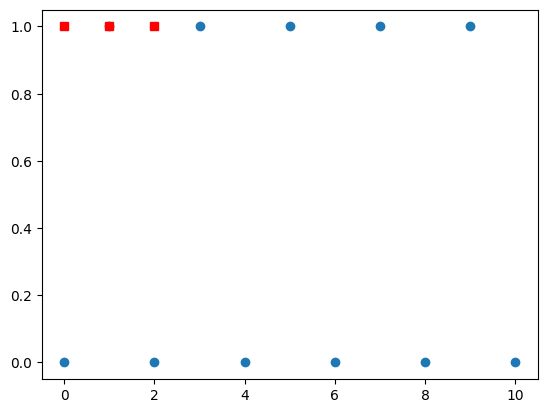

In [9]:
signal_df = modeling.synthetic_daily_signal(start_date="2020-1-1", end_date="2020-12-31", variance=0)

# Set distance to 3, meaning peaks must be at least 3 days apart
peaks, _ = scipy.signal.find_peaks(signal, distance=3)

print("Detected peaks at indices:", peaks)


plt.plot(signal, linestyle=" ", marker='o')
plt.plot(signal[peaks], marker='s', color='red', linestyle=' ')